In [ ]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.11/dist-packages/tensorflow/python/debug/cli/debugger_cli_common.py:19: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/util.py:52: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs.
  from jax import xla_computation as _xla_computation


In [ ]:
Display(visible=0, size=(840, 480)).start();

tf.random.set_seed(utils.SEED)

In [ ]:
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

In [ ]:
env = gym.make('LunarLander-v2')

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


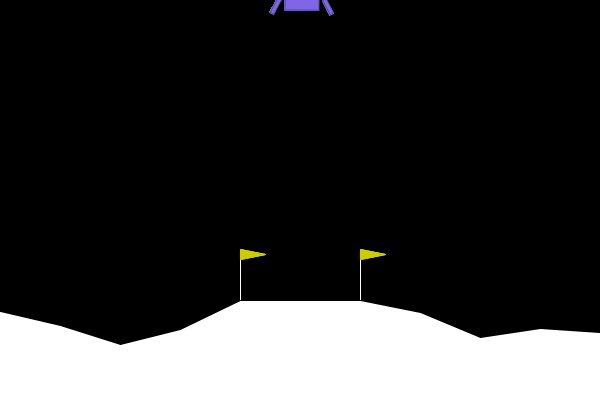

In [ ]:
env.reset()
PIL.Image.fromarray(env.render(mode='rgb_array'))

In [ ]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [ ]:
initial_state = env.reset()

In [ ]:
action = 0

next_state, reward, done, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

Initial State: [0.001 1.408 0.145 -0.136 -0.002 -0.033 0.000 0.000]
Action: 0
Next State: [0.004 1.400 0.145 -0.188 -0.005 -0.032 0.000 0.000]
Reward Received: -1.791045605487767
Episode Terminated: False
Info: {}


In [ ]:
# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear'),
    ])

optimizer = Adam(learning_rate=ALPHA)

In [ ]:
# UNIT TEST
from public_tests import *

test_network(q_network)
test_network(target_q_network)
test_optimizer(optimizer, ALPHA)

All tests passed!
All tests passed!
All tests passed!


In [ ]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [ ]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    states, actions, rewards, next_states, done_vals = experiences

    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))

    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))


    loss = MSE(y_targets, q_values)

    return loss

In [ ]:
# UNIT TEST
test_compute_loss(compute_loss)

All tests passed!


In [ ]:
@tf.function
def agent_learn(experiences, gamma):

    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)

    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    utils.update_target_network(q_network, target_q_network)

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100
epsilon = 1.0

memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        state_qn = np.expand_dims(state, axis=0)
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        next_state, reward, done, _ = env.step(action)

        memory_buffer.append(experience(state, action, reward, next_state, done))

        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:

            experiences = utils.get_experiences(memory_buffer)

            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -148.20
Episode 200 | Total point average of the last 100 episodes: -78.12
Episode 300 | Total point average of the last 100 episodes: -41.77
Episode 400 | Total point average of the last 100 episodes: 46.20
Episode 500 | Total point average of the last 100 episodes: 163.13
Episode 600 | Total point average of the last 100 episodes: 198.69
Episode 603 | Total point average of the last 100 episodes: 199.70

Episode 604 | Total point average of the last 100 episodes: 201.93

Environment solved in 604 episodes!

Total Runtime: 1894.60 s (31.58 min)


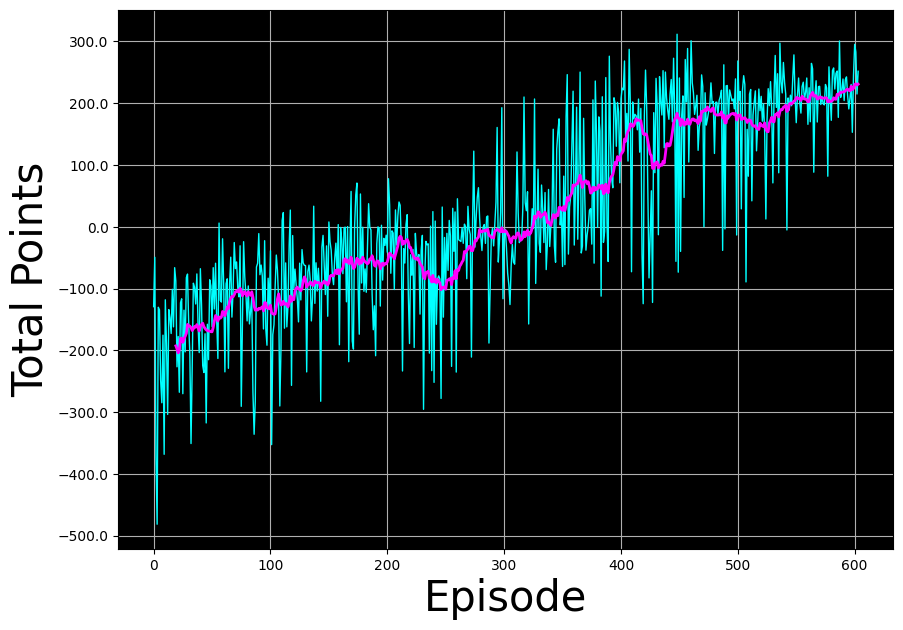

In [ ]:
# Plot the point history
utils.plot_history(total_point_history)

In [ ]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initi

In [ ]:
import os

# Create the directory if it doesn't exist
if not os.path.exists('./videos'):
    os.makedirs('./videos')